<a href="https://colab.research.google.com/github/mars241/CheckPoints/blob/main/Corr_Correction_Checkpoint_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chargement des librairies

In [ ]:
import pandas as pd
import numpy as np
#from pandas_profiling import ProfileReport
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import nltk.corpus
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [ ]:
#On créé la métrique "median_absolute_percentage_error" non-présente de base dans scikit-learn
def median_absolute_percentage_error(actual, predicted):
    return np.median((np.abs(np.subtract(actual, predicted) / actual))) * 100

### Chargement des données

In [ ]:
wine = pd.read_csv("https://github.com/murpi/wilddata/raw/master/wine.zip")
croix = pd.read_csv("https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv")

In [ ]:
#Utilisation de Pandas Profiling
#ProfileReport(wine, title="Wine_report").to_file("wine_eda.html")
#ProfileReport(croix, title="Croix_report").to_file("croix_eda.html")

In [ ]:
#Intégration des vins du Domaine des Croix au dataset global
wine = pd.concat([wine, croix]).reset_index(drop=True)

In [ ]:
wine.shape

(129971, 13)

In [ ]:
#Nettoyage des doublons
wine = wine.drop_duplicates()

In [ ]:
wine.shape

(119989, 13)

### Extraction du millésime

In [ ]:
#Extraction des dates contenues dans les colonnes title, designation et winery
wine["designation_year"] = wine.designation.str.findall("\d{4}").fillna("0")
wine["title_year"] = wine.title.str.findall("\d{4}")
wine["winery_year"] = wine.winery.str.findall("\d{4}")

In [ ]:
#Les '0' caractérisant les nan sont mis dans une liste pour faciliter leur traitement
wine["designation_year"] = wine.designation_year.apply(lambda x: list(x) if x == '0' else x)

In [ ]:
#Création de la colonne millésime qui contient pour l'instant toutes les dates récupérées
#et filtration des "0"
wine["millesime"] = ((wine.title_year + wine.designation_year + wine.winery_year)
                     .apply(lambda x: [i for i in x if i != "0"]))

In [ ]:
#Drop des dates qui se trouvent plus d'une fois dans la liste
#On part du principe que la date restante est celle du millésime
wine["millesime"] = wine["millesime"].apply(lambda x: [i for i in x if x.count(i) < 2])

In [ ]:
#Visualisation des cas qui n'ont pas marché avec cette méthode
#Ici le problème est du à des irrégularités dans la base de données
wine.loc[wine[wine.millesime.apply(len) > 1].index].set_index("title")[["designation", "millesime"]].tail(50)

,designation,millesime
title,,
Hazlitt 1854 Vineyards 2016 Cabernet Franc (Finger Lakes),NaN,"[1854, 2016, 1852]"
1850 Winery 2016 Fifth Generation Chardonnay (Judean Hills),Fifth Generation,"[1850, 2016, 1848]"
Foxen 7202 2018 Vogelzang Vineyard Cabernet Sauvignon (Happy Canyon of Santa Barbara),Vogelzang Vineyard,"[7202, 2018, 7200]"
Hazlitt 1854 Vineyards 2017 Cabernet Sauvignon (Finger Lakes),NaN,"[1854, 2017, 1852]"
Hazlitt 1854 Vineyards 2018 Barrel Fermented Chardonnay (Finger Lakes),Barrel Fermented,"[1854, 2018, 1852]"
Donna Olimpia 1900 2018 Bolgheri,NaN,"[1900, 2018, 1898]"
Cristobal 1494 2011 Cabernet Sauvignon (Mendoza),NaN,"[1494, 2011, 1492]"
Antichi Vinai 1879 2019 Il Mascalese Nerello Mascalese (Terre Siciliane),Il Mascalese,"[1879, 2019, 1877]"
Hazlitt 1854 Vineyards 2018 Pinot Gris (Finger Lakes),NaN,"[1854, 2018, 1852]"


In [ ]:
def get_millesime(liste_number):
    if len(liste_number) == 1:
        return liste_number[0]
    elif len(liste_number) == 3:
        if int(liste_number[1]) < 2003:
            return max(liste_number)
        else:
            return liste_number[1]
    else:
        return np.nan

In [ ]:
#Récupération des valeurs finales
wine["millesime extracted"] = wine.millesime.apply(get_millesime).astype(float)

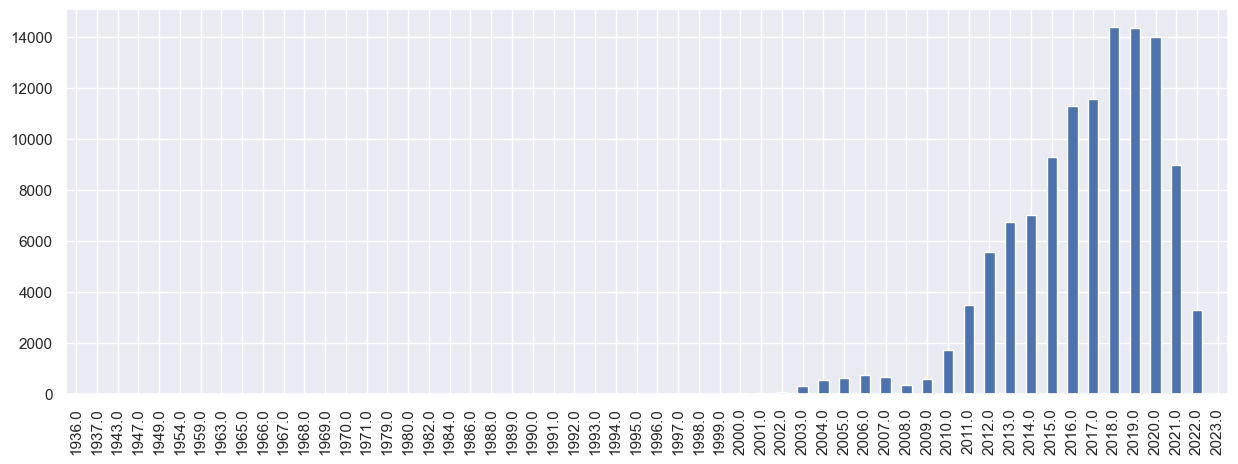

In [ ]:
wine["millesime extracted"].value_counts().sort_index().plot.bar(figsize=(15,5));

In [ ]:
wine.loc[wine[wine.millesime.apply(len) > 1].index].set_index("title")[["designation", "millesime", "millesime extracted"]].tail(50)

,designation,millesime,millesime extracted
title,,,
Hazlitt 1854 Vineyards 2016 Cabernet Franc (Finger Lakes),NaN,"[1854, 2016, 1852]",2016.0
1850 Winery 2016 Fifth Generation Chardonnay (Judean Hills),Fifth Generation,"[1850, 2016, 1848]",2016.0
Foxen 7202 2018 Vogelzang Vineyard Cabernet Sauvignon (Happy Canyon of Santa Barbara),Vogelzang Vineyard,"[7202, 2018, 7200]",2018.0
Hazlitt 1854 Vineyards 2017 Cabernet Sauvignon (Finger Lakes),NaN,"[1854, 2017, 1852]",2017.0
Hazlitt 1854 Vineyards 2018 Barrel Fermented Chardonnay (Finger Lakes),Barrel Fermented,"[1854, 2018, 1852]",2018.0
Donna Olimpia 1900 2018 Bolgheri,NaN,"[1900, 2018, 1898]",2018.0
Cristobal 1494 2011 Cabernet Sauvignon (Mendoza),NaN,"[1494, 2011, 1492]",2011.0
Antichi Vinai 1879 2019 Il Mascalese Nerello Mascalese (Terre Siciliane),Il Mascalese,"[1879, 2019, 1877]",2019.0
Hazlitt 1854 Vineyards 2018 Pinot Gris (Finger Lakes),NaN,"[1854, 2018, 1852]",2018.0


In [ ]:
wine = wine.drop(columns=["taster_twitter_handle", "designation_year", "title_year", "winery_year", "millesime"])

In [ ]:
wine = wine.rename({"millesime extracted":"millesime"}, axis="columns")

In [ ]:
#Visualisation des outliers au niveau du millésime en comparant au prix
#Les résultats sont cohérents avec des prix relativement élevés
(wine[wine.millesime < 1980][["millesime", "price", "title"]]
 .sort_values(by="millesime").set_index("title"))

,millesime,price
title,,
Adega Viuva Gomes 1936 Reserva Velho Red (Colares),1936.0,715.0
Kopke 1937 Colheita White (Port),1937.0,1396.0
Kopke 1943 Colheita Tawny (Port),1943.0,1100.0
Gérard Bertrand 1947 Legend Vintage Red (Rivesaltes),1947.0,516.0
"Bodegas Toro Albala, SL 1949 Don PX Reserva Especial Pedro Ximénez (Montilla-Moriles)",1949.0,383.0
Burmester 1954 Colheita Tawny (Port),1954.0,608.0
Messias 1954 Porto Envelhecido em Casco Colheita (Port),1954.0,724.0
Kopke 1959 Colheita Tawny (Port),1959.0,550.0
Cálem 1963 Colheita Tawny (Port),1963.0,474.0


### Quelques analyses

In [ ]:
#Visualisation des vins du client triés par millésime
(wine[wine.winery == "Domaine des Croix"][["title", "millesime", "variety"]]
 .set_index("title").sort_values(by="millesime"))

,millesime,variety
title,,
Domaine des Croix 2014 Pertuisots Premier Cru (Beaune),2014.0,Pinot Noir
Domaine des Croix 2014 Corton-Charlemagne,2014.0,Chardonnay
Domaine des Croix 2015 Beaune,2015.0,Pinot Noir
Domaine des Croix 2016 Corton Grèves,2016.0,Pinot Noir
Domaine des Croix 2016 Beaune,2016.0,Pinot Noir
Domaine des Croix 2016 Grèves (Corton),2016.0,Pinot Noir
Domaine des Croix 2017 La Vigne au Saint (Corton),2017.0,Pinot Noir
Domaine des Croix 2017 Les Grèves Premier Cru (Beaune),2017.0,Pinot Noir
Domaine des Croix 2018 Les Cent-Vignes Premier Cru (Beaune),2018.0,Pinot Noir


In [ ]:
#Création de la colonne "Premier Cru", grosse importance sur le prix quand la mention est présente dans "title"
wine["Premier Cru"] = wine.title.apply(lambda x: 1 if "Premier Cru" in x else 0)
wine.groupby("Premier Cru")["price"].agg(["mean", "median"])

,mean,median
Premier Cru,,
0,36.474681,29.0
1,64.531762,56.0


In [ ]:
#les pays qui ont les meilleures notes et utilisation de la méthode agg
wine.groupby("country").points.agg(["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
country,,
England,91.746032,63
India,90.250000,8
Austria,90.129532,3034
Germany,89.895582,1992
Canada,89.309735,226
Hungary,89.294574,129
China,89.000000,1
France,88.866808,20354
Luxembourg,88.800000,5


In [ ]:
#Même chose avec les moyennes de notes par cépage
wine.groupby("variety").points.agg(["mean", "count"]).sort_values(by="count", ascending=False).head(50)

,mean,count
variety,,
Pinot Noir,89.426582,12279
Chardonnay,88.323059,10868
Cabernet Sauvignon,88.617308,8840
Red Blend,88.368919,8243
Bordeaux-style Red Blend,89.136764,6471
Riesling,89.478106,4773
Sauvignon Blanc,87.384918,4575
Syrah,89.303030,3828
Rosé,86.766770,3220


### Wordclouds

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
stopwords.update({"wine", "drink", "fruit", "flavor", "acidity", "finish"}) #rajout de stopwords
wordcloud = WordCloud(width=480, height=480, max_font_size=200, min_font_size=10)

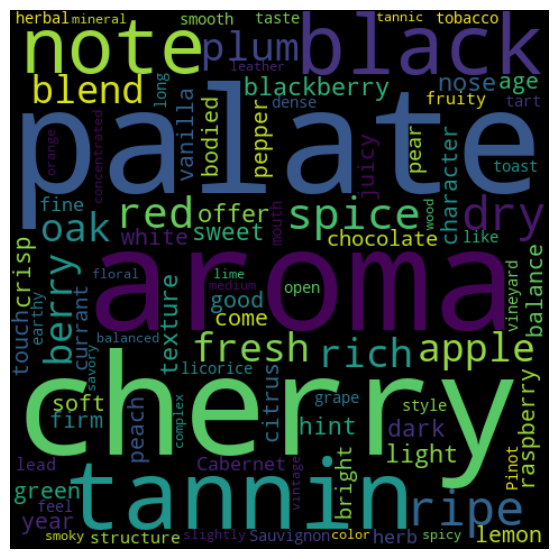

In [ ]:
#Wordcloud toute la base
sentence = " ".join(wine.sample(1000).description)
sent_tokens = nlp(sentence)
dico = nltk.FreqDist([token.lemma_ for token in sent_tokens
                      if (token.lemma_ not in stopwords) and (token.lemma_.isalpha())])
wordcloud.generate_from_frequencies(dico)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

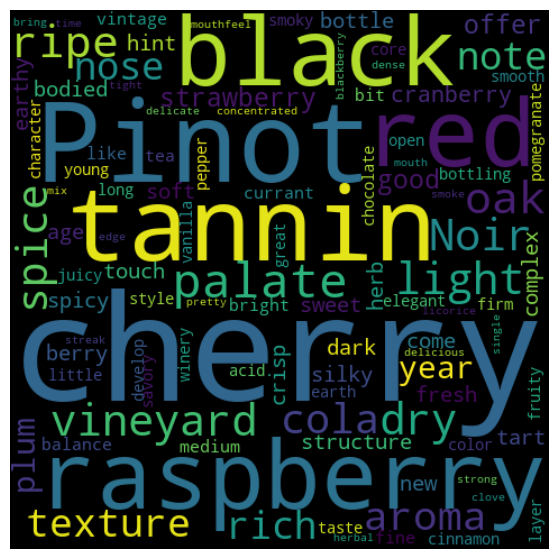

In [ ]:
#Wordcloud Pinot Noir
sentence = " ".join(wine[wine.variety == "Pinot Noir"].sample(1000).description)
sent_tokens = nlp(sentence)
dico = nltk.FreqDist([token.lemma_ for token in sent_tokens
                      if (token.lemma_ not in stopwords) and (token.lemma_.isalpha())])
wordcloud.generate_from_frequencies(dico)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

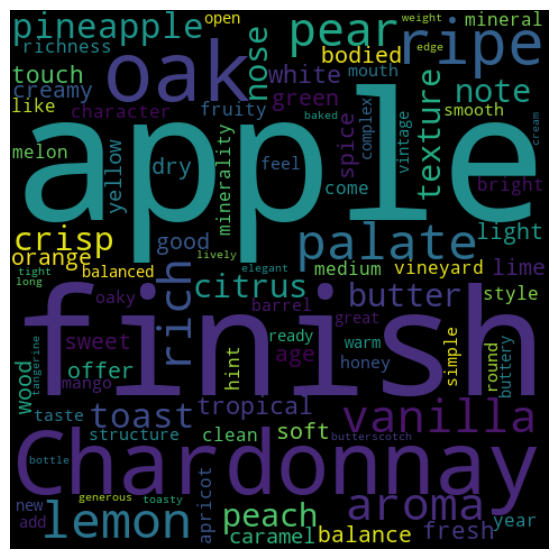

In [ ]:
#Wordcloud Chardonnay
sentence = " ".join(wine[wine.variety == "Chardonnay"].sample(1000).description)
sent_tokens = nlp(sentence)
dico = nltk.FreqDist([token.lemma_ for token in sent_tokens
                      if (token.lemma_ not in stopwords) and (token.lemma_.isalpha())])
wordcloud.generate_from_frequencies(dico)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

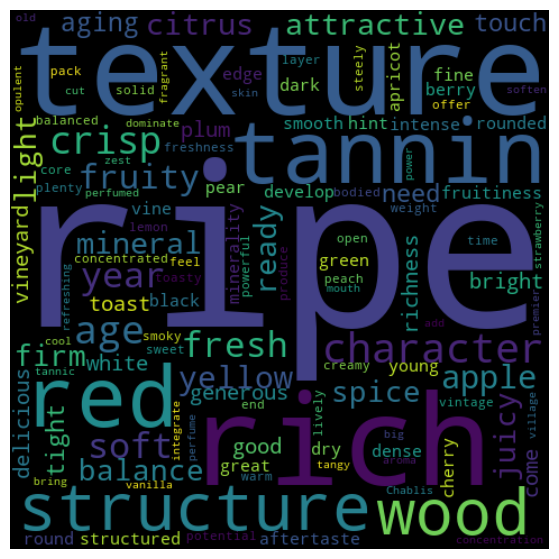

In [ ]:
#Wordcloud vins de Bourgogne
stopwords = nlp.Defaults.stop_words
sentence = " ".join(wine[wine.province == "Burgundy"].sample(1000).description)
sent_tokens = nlp(sentence)
dico = nltk.FreqDist([token.lemma_ for token in sent_tokens
                      if (token.lemma_ not in stopwords) and (token.lemma_.isalpha())])
wordcloud.generate_from_frequencies(dico)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

### Prédictions de prix et Machine Learning

In [ ]:
#On remplace les nan dans la colonne millésime par un outlier
wine["millesime"] = wine.millesime.fillna(-9999)

In [ ]:
#Drop des lignes avec un prix à nan sauf ceux du Domaine des Croix
prices_nan = wine[(wine.price.isna()) & (wine.winery != "Domaine des Croix")].index
wine = wine.drop(index=prices_nan)

#### Modèle spécialisé pour le Pinot Noir du client

In [ ]:
#Mise en place des filtres client
pinot_burg = wine[(wine.variety == "Pinot Noir") &
                  (wine.province == "Burgundy") &
                  (wine.millesime >= 2014) &
                  (wine.millesime <= 2019)].copy()

 Mean prices 76 $ 
 Median prices 54 $


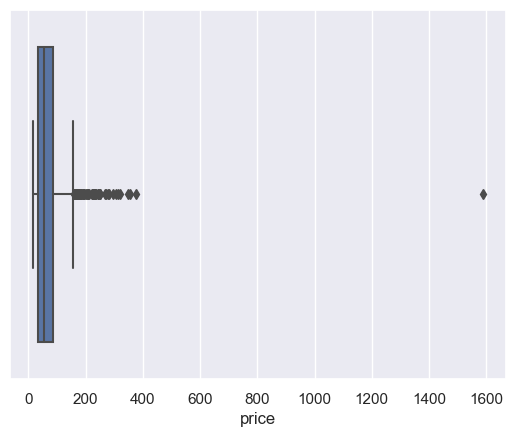

In [ ]:
#Attention aux outliers sur les prix !!
print(" Mean prices", round(pinot_burg.price.mean()), "$ \n", "Median prices",
      round(pinot_burg.price.median()), "$")
sns.boxplot(x = pinot_burg.price);

In [ ]:
pinot_burg = pinot_burg.drop(columns=["country", "province", "taster_name", "region_2",
                                        "designation", "title", "variety", "description"])

In [ ]:
#On ne garde que les régions du client pour l'encodage et on drop les autres
keep_region = croix.region_1.unique()
pinot_burg["region_1"] = pinot_burg.region_1.apply(lambda x: x if x in keep_region else "Other")
pinot_burg = (pd.get_dummies(pinot_burg, columns=["region_1"]).drop(columns="region_1_Other"))

In [ ]:
pinot_burg["millesime"] = pinot_burg["millesime"].astype(int)
#On récupère les données du client pour la prédiction
croix_pinot = pinot_burg[pinot_burg.winery == "Domaine des Croix"].drop(columns="winery")

In [ ]:
pinot_burg = pinot_burg.drop(index=croix_pinot.index).drop(columns="winery")
pinot_burg["price"] = pinot_burg["price"].astype(int)

In [ ]:
dt = DecisionTreeRegressor(max_depth=23, min_samples_split=11, min_samples_leaf=5)

##### Point sur le choix de la métrique

Mean Absolute Error (Moyenne des erreurs absolues) : Pas une bonne métrique dans notre cas car présence de valeurs extrêmes dans les prix qui vont surévaluer la prédiction

Median Absolute Error (Médiane des erreurs absolues) : Meilleur choix car on annule l'effet des valeurs extrêmes, mais manque de contexte. Pas la même signification d'une erreur de 5 dollars pour un vin à 20 ou 100 dollars

Median Absolute Percentage Error (Médiane des erreurs absolues en pourcentage du prix) : Le meilleur choix, répond parfaitement à la problématique client car l'erreur est toujours mesurée dans le contexte du prix et les valeurs extrêmes sont lissées

In [ ]:
X = pinot_burg.drop(columns='price')
y = pinot_burg.price
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Mean Absolute Error ", round(mean_absolute_error(y_test, y_pred)), "$")
print("Median Absolute Error ", round(median_absolute_error(y_test, y_pred)), "$")
print("Mean Absolute Percentage Error ", round(mean_absolute_percentage_error(y_test, y_pred) * 100), "%")
print("Median Absolute Percentage Error ", round(median_absolute_percentage_error(y_test, y_pred)), "%")
print("\n")

Mean Absolute Error  24 $
Median Absolute Error  10 $
Mean Absolute Percentage Error  31 %
Median Absolute Percentage Error  21 %




In [ ]:
#Features importances pour l'interprétabilité
(pd.DataFrame(dt.feature_importances_, index=X.columns, columns=["feature importances"])
 .sort_values(by="feature importances", ascending=False))

,feature importances
points,0.866060
Premier Cru,0.078934
millesime,0.039653
region_1_Corton,0.011897
region_1_Beaune,0.003297
region_1_Savigny-lès-Beaune,0.000158
region_1_Corton Grèves,0.000000


In [ ]:
#Prédictions finales
dt.fit(X, y)
pinot_preds = dt.predict(croix_pinot.drop(columns="price"))
pinot_client = croix[croix.variety == "Pinot Noir"].copy()
pinot_client["price"] = pinot_preds.round().astype(int)
pinot_client["fourchette basse"] = round(pinot_client.price - pinot_client.price *
                                         (median_absolute_percentage_error(y_test, y_pred) / 100)).astype(int)
pinot_client["fourchette haute"] = round(pinot_client.price + pinot_client.price *
                                         (median_absolute_percentage_error(y_test, y_pred) / 100)).astype(int)
pinot_client[["title", "variety", "price", "fourchette basse", "fourchette haute"]].set_index("title")

,variety,price,fourchette basse,fourchette haute
title,,,,
Domaine des Croix 2016 Corton Grèves,Pinot Noir,118,93,143
Domaine des Croix 2017 La Vigne au Saint (Corton),Pinot Noir,87,69,105
Domaine des Croix 2016 Beaune,Pinot Noir,63,50,76
Domaine des Croix 2019 Beaune,Pinot Noir,44,35,53
Domaine des Croix 2017 Les Grèves Premier Cru (Beaune),Pinot Noir,69,55,83
Domaine des Croix 2015 Beaune,Pinot Noir,50,40,60
Domaine des Croix 2018 Les Cent-Vignes Premier Cru (Beaune),Pinot Noir,56,44,68
Domaine des Croix 2016 Grèves (Corton),Pinot Noir,124,98,150
Domaine des Croix 2018 La Vigne au Saint (Corton),Pinot Noir,87,69,105


#### Modèle spécialisé pour le Chardonnay du client

In [ ]:
chard_burg = wine[(wine.variety == "Chardonnay") &
                  (wine.province == "Burgundy") &
                  (wine.millesime == 2014)].copy()

 Mean prices 63 $ 
 Median prices 44 $


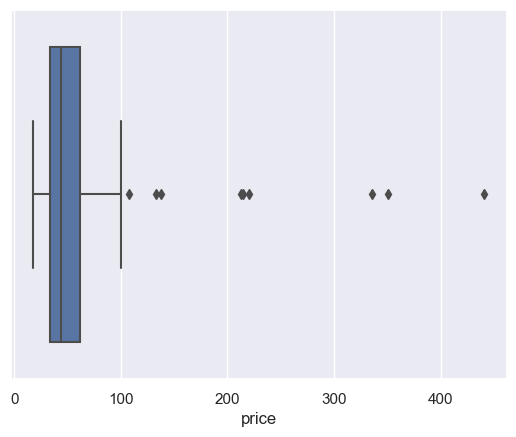

In [ ]:
print(" Mean prices", round(chard_burg.price.mean()), "$ \n", "Median prices",
      round(chard_burg.price.median()), "$")
sns.boxplot(x = chard_burg.price);

In [ ]:
chard_burg = chard_burg.drop(columns=["country", "province", "taster_name", "region_2",
                                        "designation", "title", "variety", "description"])

In [ ]:
chard_burg["region_1"] = chard_burg.region_1.apply(lambda x: x if x in keep_region else "Other")
chard_burg = (pd.get_dummies(chard_burg, columns=["region_1"]).drop(columns="region_1_Other"))

In [ ]:
chard_burg["millesime"] = chard_burg["millesime"].astype(int)
croix_chard = chard_burg[chard_burg.winery == "Domaine des Croix"].drop(columns="winery")

In [ ]:
chard_burg = chard_burg.drop(index=croix_chard.index).drop(columns="winery")
chard_burg["price"] = chard_burg["price"].astype(int)

In [ ]:
dt = DecisionTreeRegressor(max_depth=8)

In [ ]:
X = chard_burg.drop(columns='price')
y = chard_burg.price
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Mean Absolute Error ", round(mean_absolute_error(y_test, y_pred)), "$")
print("Median Absolute Error ", round(median_absolute_error(y_test, y_pred)), "$")
print("Median Absolute Percentage Error ", round(median_absolute_percentage_error(y_test, y_pred)), "%")
print("\n")

Mean Absolute Error  13 $
Median Absolute Error  12 $
Median Absolute Percentage Error  27 %




In [ ]:
(pd.DataFrame(dt.feature_importances_, index=X.columns, columns=["feature importances"])
 .sort_values(by="feature importances", ascending=False))

,feature importances
points,0.975027
Premier Cru,0.024973
millesime,0.000000
region_1_Beaune,0.000000
region_1_Corton-Charlemagne,0.000000
region_1_Savigny-lès-Beaune,0.000000


In [ ]:
dt.fit(X, y)
chard_preds = dt.predict(croix_chard.drop(columns="price"))
pinot_client = croix[croix.variety == "Chardonnay"].copy()
pinot_client["price"] = chard_preds.round().astype(int)
pinot_client["fourchette basse"] = round(pinot_client.price - pinot_client.price *
                                         (median_absolute_percentage_error(y_test, y_pred) / 100)).astype(int)
pinot_client["fourchette haute"] = round(pinot_client.price + pinot_client.price *
                                         (median_absolute_percentage_error(y_test, y_pred) / 100)).astype(int)
pinot_client[["title", "variety", "price", "fourchette basse", "fourchette haute"]].set_index("title")

,variety,price,fourchette basse,fourchette haute
title,,,,
Domaine des Croix 2014 Corton-Charlemagne,Chardonnay,108,78,138
